# Image Captioning: Exploratory Data Analysis

This notebook performs exploratory data analysis on the Flickr8k dataset:
- Dataset statistics
- Caption analysis
- Image properties
- Vocabulary analysis

In [ ]:
# Setup and imports
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm

# Add project root to path
project_root = os.path.dirname(os.getcwd())
sys.path.append(project_root)

# Import project modules
from src.utils.manager import ConfigManager
from src.utils.config import load_config
from src.utils.constants import SEED
from src.preprocessing.vocabulary import preprocess_caption

# Set style
plt.style.use('default')

# Set random seed
np.random.seed(SEED)

In [2]:
# Load configuration using ConfigManager
from src.utils.manager import ConfigManager

# Initialize configuration manager
config_manager = ConfigManager()

# Get configurations
data_config = config_manager.get_data_params()

# Get paths from config manager
captions_file = data_config['dataset']['captions_file']
images_dir = data_config['dataset']['images_dir']

print(f"Captions file: {captions_file}")
print(f"Images directory: {images_dir}")

# Check if files exist
print(f"\nCaptions file exists: {os.path.exists(captions_file)}")
print(f"Images directory exists: {os.path.exists(images_dir)}")

Captions file: c:\Users\dmxocean\Desktop\LAST\data\raw\flickr8k\captions.txt
Images directory: c:\Users\dmxocean\Desktop\LAST\data\raw\flickr8k\images

Captions file exists: True
Images directory exists: True


## Load and Explore Dataset

In [3]:
# Note: captions_file path is already set from the previous cell
print(f"Loading from: {captions_file}")

Loading from: c:\Users\dmxocean\Desktop\LAST\data\raw\flickr8k\captions.txt


In [4]:
# Load captions
captions_df = pd.read_csv(captions_file)
print(f"Dataset shape: {captions_df.shape}")
print(f"\nColumns: {captions_df.columns.tolist()}")
print(f"\nFirst few rows:")
captions_df.head()

Dataset shape: (40455, 2)

Columns: ['image', 'caption']

First few rows:


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [5]:
# Basic statistics
num_images = len(captions_df['image'].unique())
num_captions = len(captions_df)
avg_captions_per_image = num_captions / num_images

print("Dataset Statistics:")
print(f"Total unique images: {num_images}")
print(f"Total captions: {num_captions}")
print(f"Average captions per image: {avg_captions_per_image:.2f}")

# Check caption distribution per image
caption_counts = captions_df['image'].value_counts()
print(f"\nCaptions per image distribution:")
print(caption_counts.value_counts().sort_index())

Dataset Statistics:
Total unique images: 8091
Total captions: 40455
Average captions per image: 5.00

Captions per image distribution:
count
5    8091
Name: count, dtype: int64


## Caption Analysis

In [6]:
# Process captions
print("Processing captions...")
captions_df['processed_caption'] = captions_df['caption'].apply(preprocess_caption)
captions_df['caption_length'] = captions_df['processed_caption'].apply(lambda x: len(x.split()))

# Caption length statistics
print("\nCaption Length Statistics:")
print(captions_df['caption_length'].describe())

Processing captions...

Caption Length Statistics:
count    40455.000000
mean        11.836584
std          3.918147
min          1.000000
25%          9.000000
50%         11.000000
75%         14.000000
max         40.000000
Name: caption_length, dtype: float64


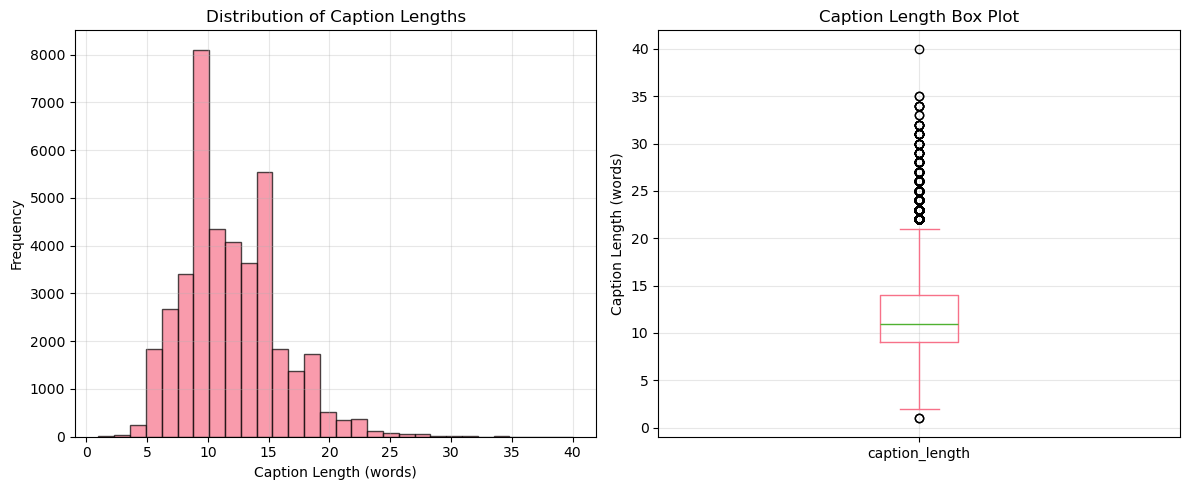

In [7]:
# Caption length distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(captions_df['caption_length'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Caption Length (words)')
plt.ylabel('Frequency')
plt.title('Distribution of Caption Lengths')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
captions_df['caption_length'].plot(kind='box')
plt.ylabel('Caption Length (words)')
plt.title('Caption Length Box Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Word frequency analysis
all_words = []
for caption in captions_df['processed_caption']:
    all_words.extend(caption.split())

word_freq = Counter(all_words)
print(f"Total unique words: {len(word_freq)}")
print(f"Total words: {len(all_words)}")

# Most common words
print("\nTop 20 most common words:")
for word, count in word_freq.most_common(20):
    print(f"{word}: {count} ({count/len(all_words)*100:.2f}%)")

Total unique words: 8504
Total words: 478849

Top 20 most common words:
a: 62991 (13.15%)
.: 36586 (7.64%)
in: 18986 (3.96%)
the: 18419 (3.85%)
on: 10745 (2.24%)
is: 9345 (1.95%)
and: 8862 (1.85%)
dog: 8138 (1.70%)
with: 7765 (1.62%)
man: 7274 (1.52%)
of: 6723 (1.40%)
two: 5642 (1.18%)
white: 3959 (0.83%)
black: 3848 (0.80%)
boy: 3581 (0.75%)
are: 3504 (0.73%)
woman: 3402 (0.71%)
girl: 3328 (0.69%)
,: 3232 (0.67%)
to: 3176 (0.66%)


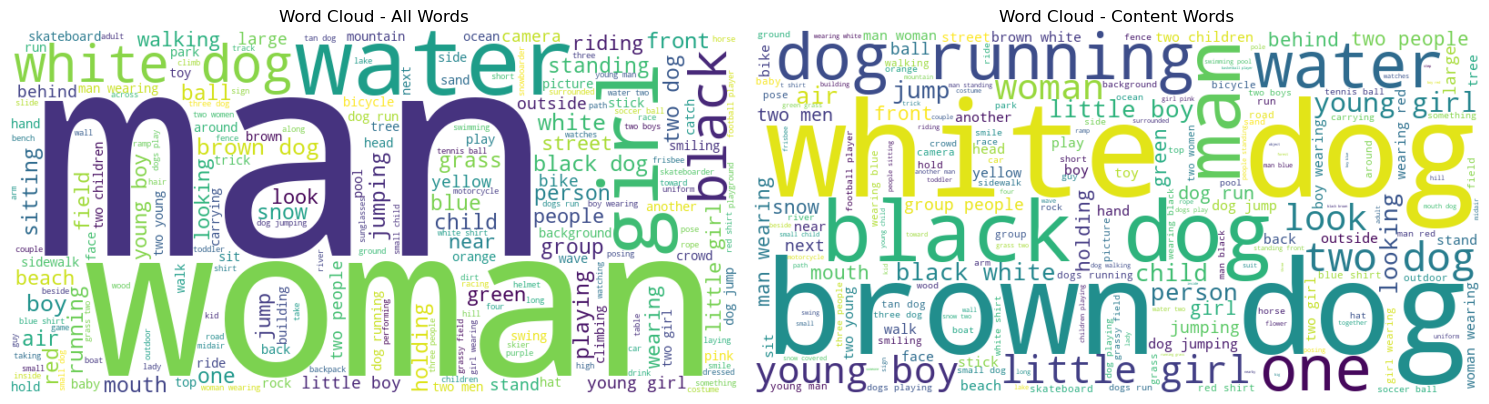

In [9]:
# Word cloud visualization
plt.figure(figsize=(15, 8))

# All words
plt.subplot(1, 2, 1)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud - All Words')
plt.axis('off')

# Without stopwords
plt.subplot(1, 2, 2)
# Filter out common words
stopwords = {'a', 'an', 'the', 'is', 'in', 'on', 'and', 'of', 'with', 'at', 'to', 'are'}
filtered_words = [w for w in all_words if w not in stopwords]
wordcloud_filtered = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_words))
plt.imshow(wordcloud_filtered, interpolation='bilinear')
plt.title('Word Cloud - Content Words')
plt.axis('off')

plt.tight_layout()
plt.show()

## Image Analysis

In [10]:
# Sample images for analysis
sample_images = captions_df['image'].unique()[:100]  # Analyze first 100 images

# Collect image properties
image_properties = []

for img_name in tqdm(sample_images, desc="Analyzing images"):
    img_path = os.path.join(images_dir, img_name)
    if os.path.exists(img_path):
        img = Image.open(img_path)
        image_properties.append({
            'filename': img_name,
            'width': img.width,
            'height': img.height,
            'aspect_ratio': img.width / img.height,
            'mode': img.mode,
            'format': img.format
        })

image_df = pd.DataFrame(image_properties)

Analyzing images: 100%|██████████| 100/100 [00:00<00:00, 4984.02it/s]


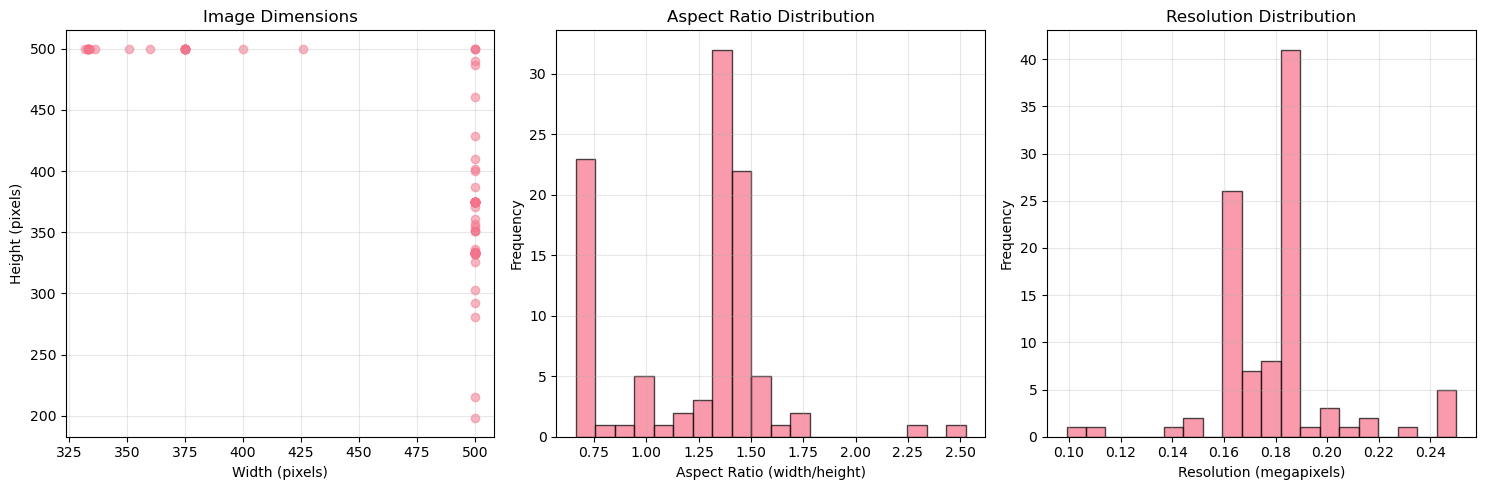

Image Statistics:
Average width: 464.9 pixels
Average height: 397.8 pixels
Average aspect ratio: 1.23
Image formats: {'JPEG': 100}


In [11]:
# Image size distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(image_df['width'], image_df['height'], alpha=0.5)
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.title('Image Dimensions')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(image_df['aspect_ratio'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Aspect Ratio (width/height)')
plt.ylabel('Frequency')
plt.title('Aspect Ratio Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
image_df['resolution'] = image_df['width'] * image_df['height']
plt.hist(image_df['resolution'] / 1e6, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Resolution (megapixels)')
plt.ylabel('Frequency')
plt.title('Resolution Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Image Statistics:")
print(f"Average width: {image_df['width'].mean():.1f} pixels")
print(f"Average height: {image_df['height'].mean():.1f} pixels")
print(f"Average aspect ratio: {image_df['aspect_ratio'].mean():.2f}")
print(f"Image formats: {image_df['format'].value_counts().to_dict()}")

## Caption-Image Relationship

Sample image: 1000268201_693b08cb0e.jpg

Captions for this image:
1. A child in a pink dress is climbing up a set of stairs in an entry way .
2. A girl going into a wooden building .
3. A little girl climbing into a wooden playhouse .
4. A little girl climbing the stairs to her playhouse .
5. A little girl in a pink dress going into a wooden cabin .


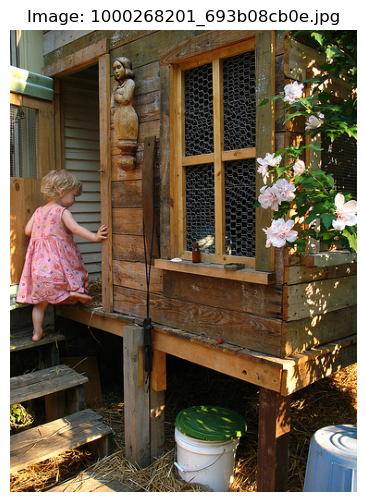

In [12]:
# Analyze caption variation for same image
sample_image = captions_df['image'].unique()[0]
sample_captions = captions_df[captions_df['image'] == sample_image]

print(f"Sample image: {sample_image}")
print(f"\nCaptions for this image:")
for i, (_, row) in enumerate(sample_captions.iterrows(), 1):
    print(f"{i}. {row['caption']}")
    
# Display the image
img_path = os.path.join(images_dir, sample_image)
img = Image.open(img_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.title(f"Image: {sample_image}")
plt.axis('off')
plt.show()

Calculating similarities: 100%|██████████| 100/100 [00:00<00:00, 232.25it/s]


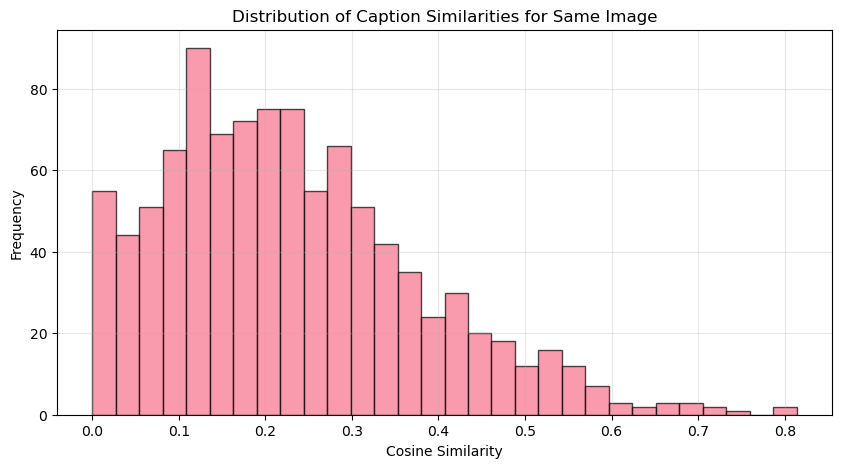

Average caption similarity: 0.230
Std caption similarity: 0.149


In [13]:
# Caption diversity analysis
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Calculate caption similarity for images with multiple captions
similarity_scores = []

for img in tqdm(captions_df['image'].unique()[:100], desc="Calculating similarities"):
    img_captions = captions_df[captions_df['image'] == img]['processed_caption'].tolist()
    if len(img_captions) > 1:
        # Calculate TF-IDF vectors
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(img_captions)
        
        # Calculate pairwise similarities
        similarities = cosine_similarity(tfidf_matrix)
        
        # Get upper triangle (excluding diagonal)
        for i in range(len(img_captions)):
            for j in range(i + 1, len(img_captions)):
                similarity_scores.append(similarities[i, j])

# Plot similarity distribution
plt.figure(figsize=(10, 5))
plt.hist(similarity_scores, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Caption Similarities for Same Image')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Average caption similarity: {np.mean(similarity_scores):.3f}")
print(f"Std caption similarity: {np.std(similarity_scores):.3f}")

## Vocabulary Analysis with Different Thresholds

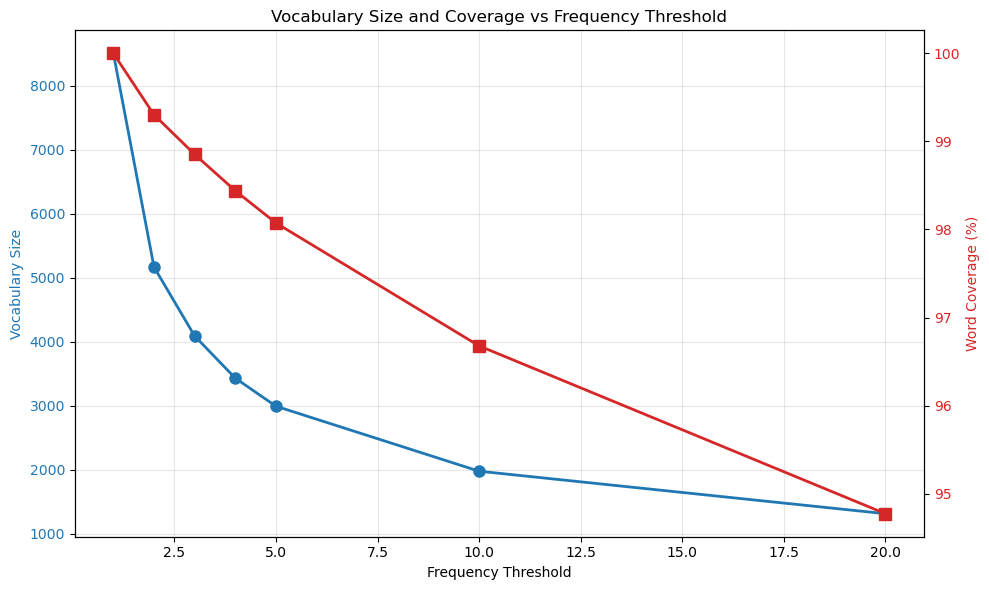

Threshold | Vocab Size | Coverage
-----------------------------------
        1 |       8508 |  100.00%
        2 |       5168 |   99.30%
        3 |       4091 |   98.85%
        4 |       3432 |   98.44%
        5 |       2994 |   98.07%
       10 |       1978 |   96.68%
       20 |       1314 |   94.77%


In [14]:
# Analyze vocabulary size with different frequency thresholds
thresholds = [1, 2, 3, 4, 5, 10, 20]
vocab_sizes = []
coverage_rates = []

for threshold in thresholds:
    # Count words above threshold
    vocab_size = sum(1 for count in word_freq.values() if count >= threshold) + 4  # +4 for special tokens
    vocab_sizes.append(vocab_size)
    
    # Calculate coverage
    covered_words = sum(count for word, count in word_freq.items() if count >= threshold)
    coverage = covered_words / len(all_words) * 100
    coverage_rates.append(coverage)

# Plot results
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Frequency Threshold')
ax1.set_ylabel('Vocabulary Size', color=color)
ax1.plot(thresholds, vocab_sizes, 'o-', color=color, linewidth=2, markersize=8)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Word Coverage (%)', color=color)
ax2.plot(thresholds, coverage_rates, 's-', color=color, linewidth=2, markersize=8)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Vocabulary Size and Coverage vs Frequency Threshold')
fig.tight_layout()
plt.show()

# Print table
print("Threshold | Vocab Size | Coverage")
print("-" * 35)
for t, v, c in zip(thresholds, vocab_sizes, coverage_rates):
    print(f"{t:9d} | {v:10d} | {c:7.2f}%")

## Summary Statistics

In [15]:
# Create summary report
print("DATASET SUMMARY")
print()
print(f"\nImages:")
print(f"  Total images: {num_images}")
print(f"  Average resolution: {image_df['resolution'].mean() / 1e6:.1f} MP")
print(f"  Most common aspect ratio: {image_df['aspect_ratio'].mode()[0]:.2f}")

print(f"\nCaptions:")
print(f"  Total captions: {num_captions}")
print(f"  Captions per image: {avg_captions_per_image:.1f}")
print(f"  Average caption length: {captions_df['caption_length'].mean():.1f} words")
print(f"  Caption length range: {captions_df['caption_length'].min()}-{captions_df['caption_length'].max()} words")

print(f"\nVocabulary:")
print(f"  Total unique words: {len(word_freq)}")
print(f"  Words with freq >= 5: {sum(1 for c in word_freq.values() if c >= 5)}")
print(f"  Most common word: '{word_freq.most_common(1)[0][0]}' ({word_freq.most_common(1)[0][1]} times)")

print(f"\nCaption Diversity:")
print(f"  Average similarity between captions: {np.mean(similarity_scores):.3f}")
print(f"  This indicates {'high' if np.mean(similarity_scores) > 0.7 else 'moderate' if np.mean(similarity_scores) > 0.4 else 'low'} similarity")

DATASET SUMMARY


Images:
  Total images: 8091
  Average resolution: 0.2 MP
  Most common aspect ratio: 1.33

Captions:
  Total captions: 40455
  Captions per image: 5.0
  Average caption length: 11.8 words
  Caption length range: 1-40 words

Vocabulary:
  Total unique words: 8504
  Words with freq >= 5: 2990
  Most common word: 'a' (62991 times)

Caption Diversity:
  Average similarity between captions: 0.230
  This indicates low similarity
